In [3]:
# display, transform, read, split ...
import numpy as np
import cv2 as cv
import os
import splitfolders
import matplotlib.pyplot as plt

# tensorflow
import tensorflow.keras as keras
import tensorflow as tf

# image processing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

# model / neural network
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.python.client import device_lib
# GPU 사용
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# CPU 사용
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# # CPU, GPU 사용 가능 여부 print
# print(device_lib.list_local_devices())

2025-03-10 17:27:03.496072: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-10 17:27:03.519313: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-10 17:27:03.519347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-10 17:27:03.519994: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-10 17:27:03.524891: I tensorflow/core/platform/cpu_feature_guar

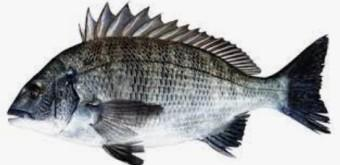

In [4]:
# 감성돔
data_full_dir = "/home/chichi/S12P21C201/src/AI/dataset/data_full"
img_gamsungdom = image.load_img(data_full_dir + "/감성돔/감성돔_0.jpg")
img_gamsungdom

### Split 데이터


In [5]:
data_split_dir = "/home/chichi/S12P21C201/src/AI/dataset/data_split"
splitfolders.ratio(data_full_dir, 
					output=data_split_dir, 
					seed=1337, ratio=(0.8, 0.1, 0.1), group_prefix=None, move=False)

Copying files: 587 files [00:00, 13563.33 files/s]


In [6]:
# split 후 파일 디렉토리 구조
# .
# ├── data_full
# │   ├── 갈치
# │   ├── 감성돔
# │   └── 갑오징어
# └── data_split
#     ├── test
#     │   ├── 갈치
#     │   ├── 감성돔
#     │   └── 갑오징어
#     ├── train
#     │   ├── 갈치
#     │   ├── 감성돔
#     │   └── 갑오징어
#     └── val
#         ├── 갈치
#         ├── 감성돔
#         └── 갑오징어

In [7]:
datagen = ImageDataGenerator()
# define classes name
class_names = ['갈치','감성돔','갑오징어']

In [8]:
# param
batch_size = 16
target_size = (224,224)
# training data
train_generator = datagen.flow_from_directory( 
    directory=data_split_dir + "/train/", 
    classes = class_names,
    target_size=target_size,  
    batch_size=batch_size, 
    class_mode="binary", 
)

# validation data
valid_generator = datagen.flow_from_directory( 
    directory=data_split_dir + "/val/", 
    classes = class_names,
    target_size=target_size,  
    batch_size=batch_size, 
    class_mode="binary", 
)

# test data
test_generator = datagen.flow_from_directory( 
    directory=data_split_dir + "/test/", 
    classes = class_names,
    target_size=target_size,  
    batch_size=batch_size, 
    class_mode="binary", 
)

Found 469 images belonging to 3 classes.


Found 58 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


### ResNet50 Model


In [9]:
# ResNet50 model
resnet_50 = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet_50.layers:
    layer.trainable = False

# build the entire model
x = resnet_50.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(3, activation='softmax')(x)
model = Model(inputs = resnet_50.input, outputs = predictions)

2025-03-10 17:27:04.618410: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-10 17:27:04.645716: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-10 17:27:04.645893: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Training

In [10]:
def trainModel(model, epochs, optimizer, batch_size):
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model.fit(train_generator, validation_data=valid_generator, epochs=epochs, batch_size=batch_size)

In [11]:
# launch the training
# hyper_param
epochs = 10
optimizer = "Adam"
model_history = trainModel(model = model, epochs = epochs, optimizer = optimizer, batch_size= batch_size)

Epoch 1/10


2025-03-10 17:27:07.589827: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-03-10 17:27:07.638940: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-03-10 17:27:08.202683: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-03-10 17:27:09.761223: I external/local_xla/xla/service/service.cc:168] XLA service 0xc1b8610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-10 17:27:09.761245: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-03-10 17:27:09.764921: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741595229.829332   27792 device_com

30/30 [==============================] - 9s 148ms/step - loss: 2.5374 - accuracy: 0.3603 - val_loss: 0.7360 - val_accuracy: 0.7241
Epoch 2/10
30/30 [==============================] - 2s 56ms/step - loss: 1.2199 - accuracy: 0.5267 - val_loss: 0.5364 - val_accuracy: 0.8793
Epoch 3/10
30/30 [==============================] - 2s 55ms/step - loss: 0.8461 - accuracy: 0.6354 - val_loss: 0.3769 - val_accuracy: 0.8621
Epoch 4/10
30/30 [==============================] - 2s 56ms/step - loss: 0.5452 - accuracy: 0.7697 - val_loss: 0.2441 - val_accuracy: 0.9138
Epoch 5/10
30/30 [==============================] - 2s 55ms/step - loss: 0.3106 - accuracy: 0.8785 - val_loss: 0.2351 - val_accuracy: 0.9138
Epoch 6/10
30/30 [==============================] - 2s 56ms/step - loss: 0.2699 - accuracy: 0.8955 - val_loss: 0.1632 - val_accuracy: 0.9483
Epoch 7/10
30/30 [==============================] - 2s 56ms/step - loss: 0.2355 - accuracy: 0.9296 - val_loss: 0.1408 - val_accuracy: 0.9655
Epoch 8/10
30/30 [=====

### Loss & Accuracy Graph

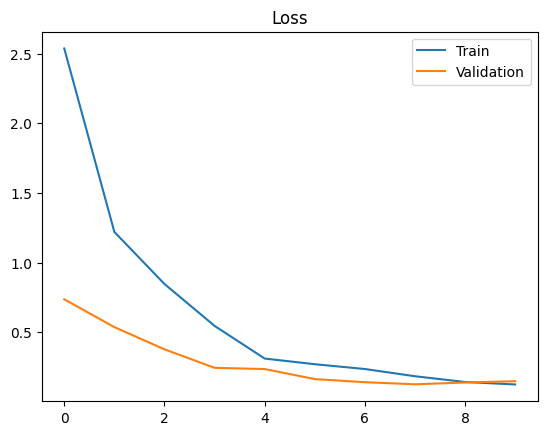

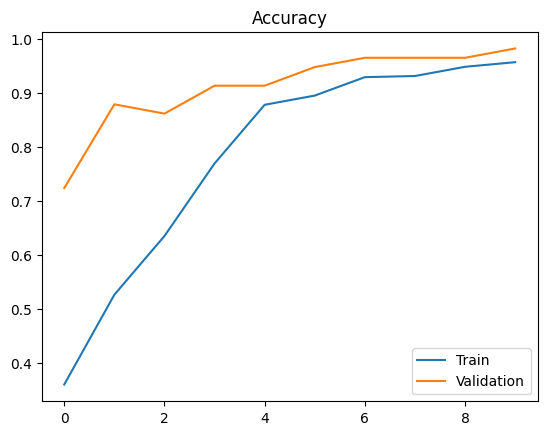

In [12]:
loss_train_curve = model_history.history["loss"]
loss_val_curve = model_history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

acc_train_curve = model_history.history["accuracy"]
acc_val_curve = model_history.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()


### 성능 평가

In [13]:
test_loss, test_acc = model.evaluate(test_generator)
print("The test loss is: ", test_loss)
print("The best accuracy is: ", test_acc*100)

4/4 [==============================] - 1s 465ms/step - loss: 0.1764 - accuracy: 0.9500
The test loss is:  0.1764211654663086
The best accuracy is:  94.9999988079071


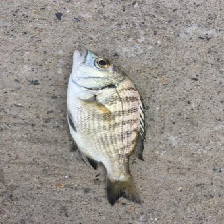

In [14]:
test_img = tf.keras.preprocessing.image.load_img('/home/chichi/S12P21C201/src/AI/dataset/data_split/test/감성돔/감성돔_41.jpg', 
                                            target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(test_img)
img_array = np.array([img_array]) 
test_img

In [15]:
# generate predictions for samples
predictions = model.predict(img_array)
print(predictions)

# generate argmax for predictions
class_id = np.argmax(predictions, axis = 1)
print(class_id)

# transform classes number into classes name
print(class_names[class_id.item()])

1/1 [==============================] - 1s 1s/step
[[2.6100338e-06 9.9997747e-01 1.9908641e-05]]
[1]
감성돔


### 모델 저장

In [19]:
# directory
model.save('/home/chichi/S12P21C201/src/AI/model_h5/three_fish_resnet')

# or h5 file
model.save('/home/chichi/S12P21C201/src/AI/model_h5/three_fish_resnet_h5')

INFO:tensorflow:Assets written to: /home/chichi/S12P21C201/src/AI/model_h5/three_fish_resnet/assets


INFO:tensorflow:Assets written to: /home/chichi/S12P21C201/src/AI/model_h5/three_fish_resnet/assets


INFO:tensorflow:Assets written to: /home/chichi/S12P21C201/src/AI/model_h5/three_fish_resnet_h5/assets


INFO:tensorflow:Assets written to: /home/chichi/S12P21C201/src/AI/model_h5/three_fish_resnet_h5/assets


In [20]:
# model load
tf.keras.models.load_model('/home/chichi/S12P21C201/src/AI/model_h5/three_fish_resnet')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          